# Lab 3: [Protein chain clustering](https://chalmers.instructure.com/courses/10918/files/918897/download?wrap=1)
* Daniel Willim:
* Erik Jergéus: 

## 1 Show the distribution of phi and psi combinations using: 

### a. A scatter plot

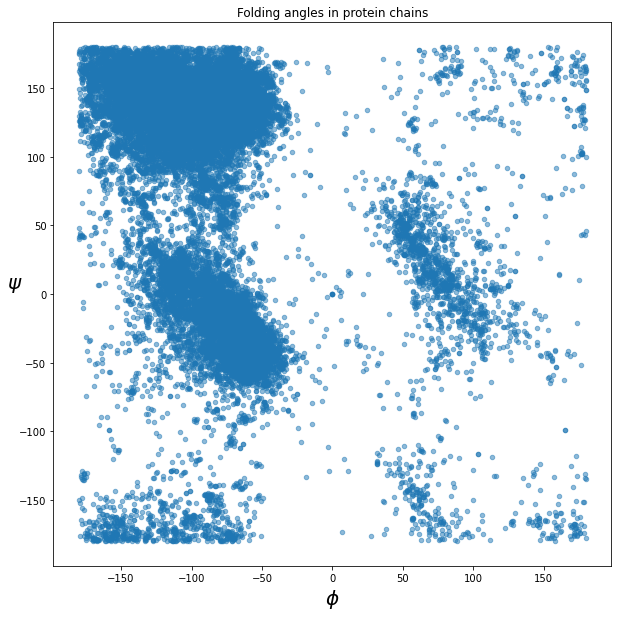

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 10]

data = pd.read_csv("data_all.csv")
data.plot.scatter(x="phi", y="psi", alpha = 0.5)
plt.title("Folding angles in protein chains")
plt.ylabel(r"$\psi$", rotation="horizontal", size=20)
plt.xlabel(r"$\phi$", size=20)
plt.show()

### b. A heatmap

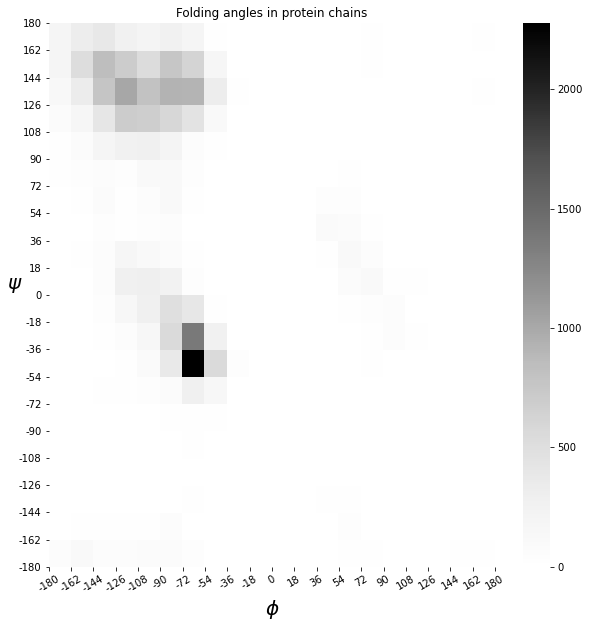

In [27]:
import numpy as np

# Set resolution of heatmap
buckets = 20

# Calulate intermiate variables
step = int(360/buckets)
breakpoints = range(-180,181,step)
breakpoints_array = [*breakpoints]
hmap = np.zeros((buckets, buckets))

# Calulate nr of points per pixel in heatmap
for i, row in data.iterrows():
    hmap[int((row.psi + 180)/step),int((row.phi + 180)/step)] += 1

# Plot heatmap    
sns.heatmap(hmap,cmap="Greys")

#Configure plot
plt.gca().invert_yaxis()
plt.xticks(range(0,buckets + 1), labels=breakpoints_array, 
           rotation=30)
plt.yticks(range(0,buckets + 1), labels=breakpoints_array, 
           rotation="horizontal")

plt.title("Folding angles in protein chains")
plt.ylabel(r"$\psi$", rotation="horizontal", size=20)
plt.xlabel(r"$\phi$", size=20)

plt.show()

## 2 Use  the  K-means  clustering  method to  cluster  the phi  and  psi  angle  combinations  in the data file. 

### a. Experiment with different values of K. Suggest an appropriate value of K for this task and motivate this choice. 

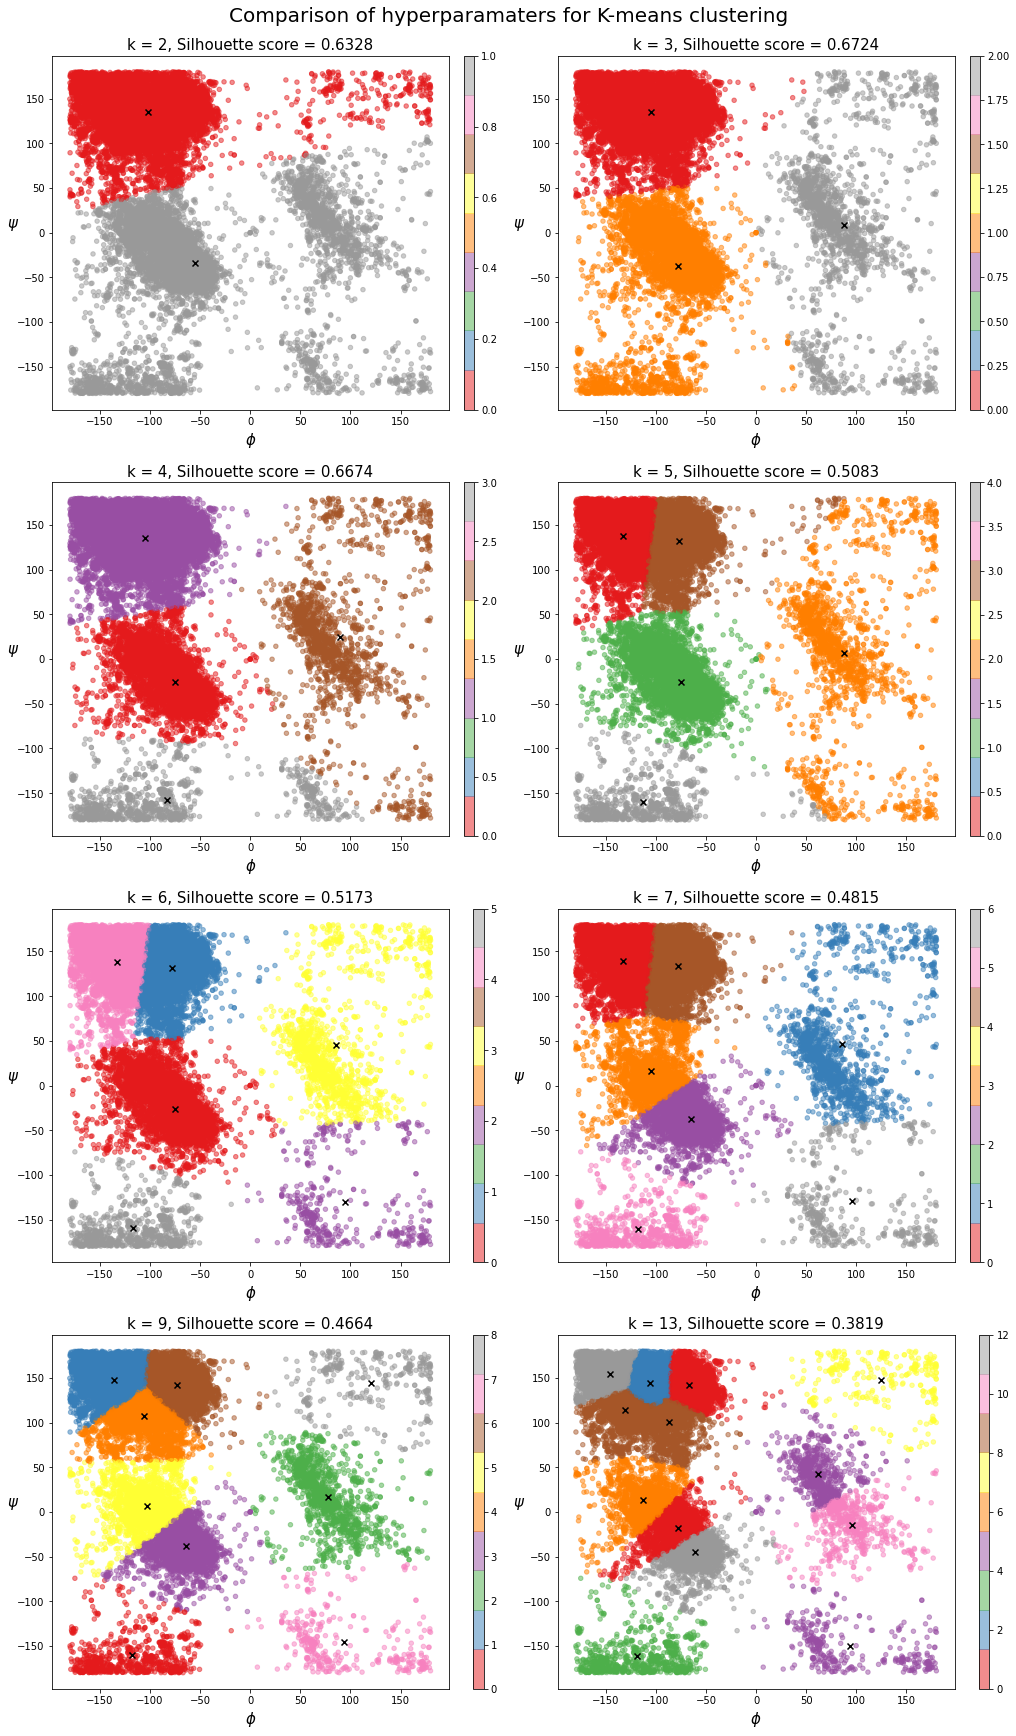

In [152]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set k values to test
ks = [2,3,4,5,6,7,9,13]

# Setup plt subfigures to hold each scatterplot
fig,axs = plt.subplots(int(len(ks)/2),2, figsize=(2*7, int(len(ks)/2)*6),
                       constrained_layout=True)
axs = axs.flatten()

# Run KMeans for each k in ks, then plot the result
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k).fit(data[["phi", "psi"]])
    clusters = kmeans.cluster_centers_
        
    data.plot.scatter(x="phi", y="psi", alpha = 0.5, ax=axs[i], c=kmeans.labels_, cmap="Set1")
    axs[i].scatter(x=clusters[:,0], y=clusters[:,1], c="Black", marker='x')
    
    axs[i].set_title(f"k = {k}, Silhouette score = {silhouette_score(data[['phi', 'psi']], kmeans.labels_):,.4f}"
                    ,size=15)
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal",size=15)
    axs[i].set_xlabel(r"$\phi$",size=15)

# Configure plot
fig.suptitle("Comparison of hyperparamaters for K-means clustering", size=20)
plt.show()

From the heatmap we can see that there is atleast 2 important clusters to the left and one less apparent to the right. Besides those there is a small cluster in the bottom left, which seems to be the residue from the top left cluster. That problem can be rectified by either making the clustering method cyclical around modulo 360 or as we do in 2d.

We used the silhouette score to get an objective score on which *k* was the best. Our original hypothesis when just looking at the plots was that a *k* of 7-9 would be the best, since then there where very few outliers. But the silhouette score weighed the misclassification of points higher than we did, and as such did not favor higher values of *k*. Furthermore we realised that the higher *k*s resulted in more volatile clusters where each random initialisation had a probability to give a different cluster.

Choosing the *k* with the best silhouette score results in *k=3*, which seems to lineup with the clusters suggested in [the assignment link](http://bioinformatics.org/molvis/phipsi/). Therefore we are relatively confindent that a *k* of 3 is optimal.


### b.Validate the clusters that are found with the chosen value of K. Hint: See the slides for Lecture 6, Section Validating clustering. 

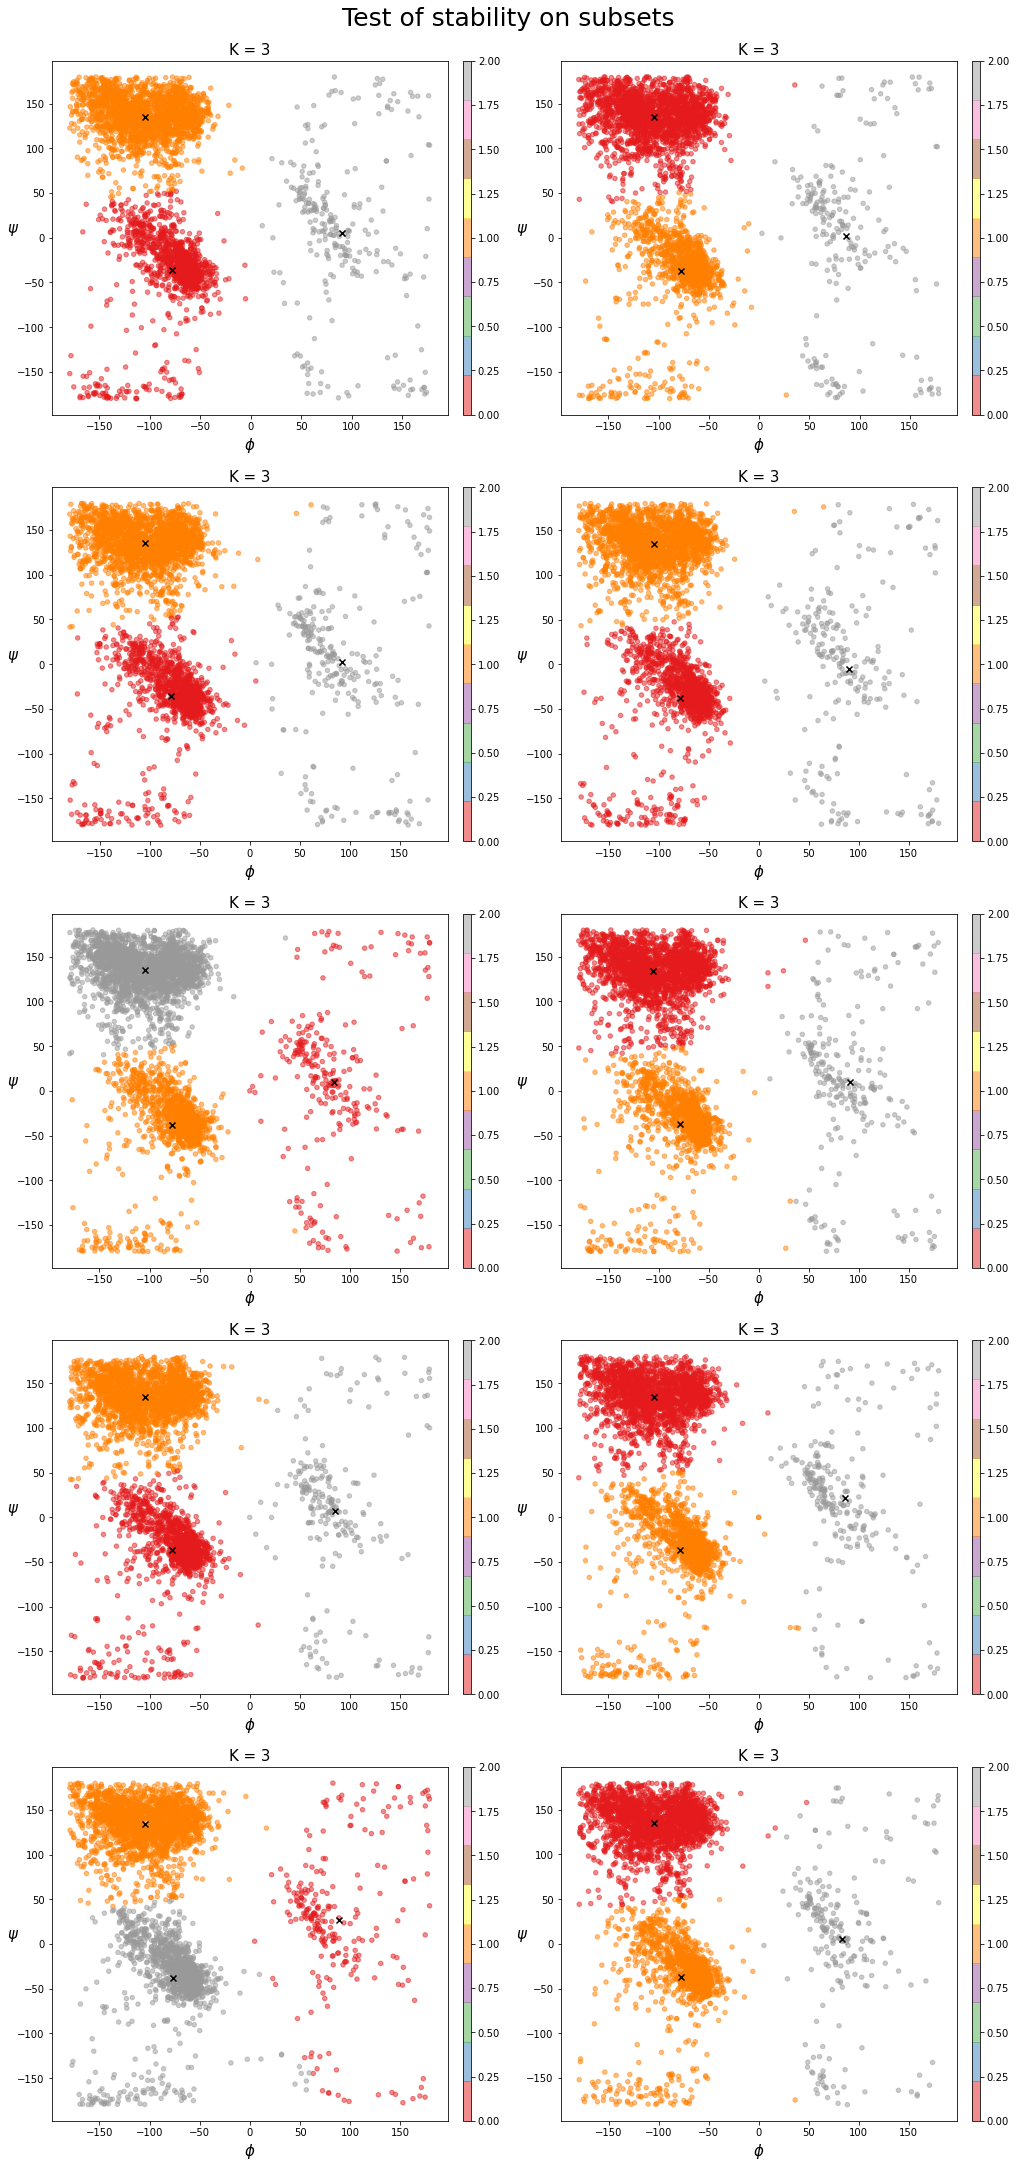

In [150]:
# Set params from test
k = 3
iterations = 10
frac = 1/8

# Create subplots for each 
fig,axs = plt.subplots(int(iterations/2),2,constrained_layout=True,
                       figsize=(2*7, int(iterations/2)*6))
axs = axs.flatten()

# Plot each test
for i in range(iterations):
    # Sample data
    sample = data.sample(frac=frac)
    sampleNumbers = sample[['phi','psi']].copy()
    
    # Run kmeans
    kmeans = KMeans(n_clusters=k).fit(sampleNumbers)
    
    # Plot result
    sample.plot.scatter(x="phi", y="psi", alpha = 0.5, ax=axs[i], c=kmeans.labels_, cmap="Set1")
    axs[i].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], c="Black", marker="x")
    axs[i].set_title(f"K = {k}", size=15)
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal", size=15)
    axs[i].set_xlabel(r"$\phi$", size=15)

# Configure plot
fig.suptitle("Test of stability on subsets", size=25)
plt.show()

We choose to validate the stability by checking samples. In the plot above we can see that despite only using 1/8th of the data we see very small disparities between the clusters. The only noticeable difference is that the right cluster seems to be more or less surrounded by its points, but the coordinates for the core point is still identical between subsets.

Eventuellt, räkna ut co-occurrence 

### c.Do the clusters found in part (a) seem reasonable? 

As discussed earlier it seems like we get reasonable clusters, since they match both the heatmap and scatterplot reasonably well and they result in a good silhouette score.

### d. Can you change the data to get better results (or the same results in a simpler way)?  (Hint:  since  both  phi  and  psi  are  periodic  attributes,  you  can  think  of shifting/translating them by some value and then use the modulo operation.) 

Since degrees are cyclical we can translate some of the points in order to minimize the amount of outliers that arise from the cluster algorithm not being able to account for modulo 360 on all angles. Some lines where the lowest amount of points appear looks to be when $\psi$ is -100 and $\phi$ is 0. Which means that all the points below those values can be added by 360 in order to make the clusters better.

The result is that all the big clusters are still the same, but there are fewer small clusters. This can be seen when *k = 4* where the bottom left cluster from before now has merged into the cluster that used to be top left. Furthermore the improvement can be seen in the new silhouette score. (See plot below)

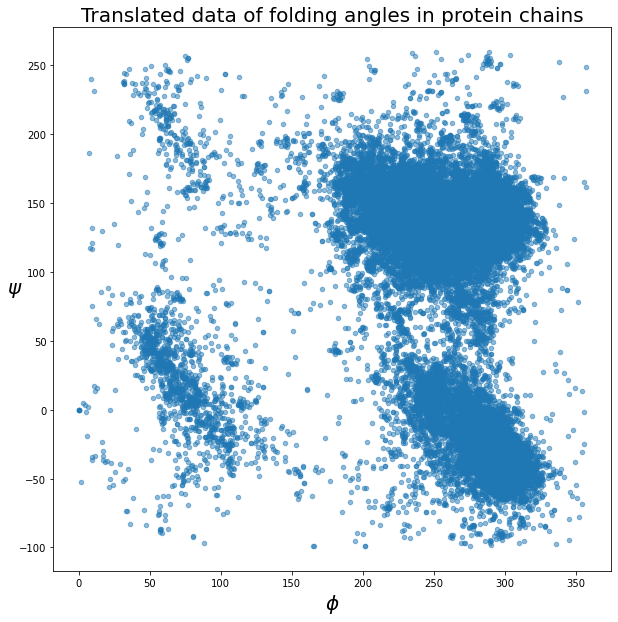

In [155]:
translated = data.copy()

# Translate psi
array = translated.psi.to_numpy()

for i,x in enumerate(array):
    if x < -100:
        array[i] = x + 360
        
translated['psi']= pd.Series(array)

# Translate phi
array = translated.phi.to_numpy()

for i,x in enumerate(array):
    if x < 0:
        array[i] = x + 360

translated['phi']= pd.Series(array)

# Plot translated data
translated.plot.scatter(x="phi", y="psi", alpha = 0.5)

# Configure plot
plt.title("Translated data of folding angles in protein chains", size=20)
plt.ylabel(r"$\psi$", rotation="horizontal", size=20)
plt.xlabel(r"$\phi$", size=20)

plt.show()

# TODO fix axis labels 

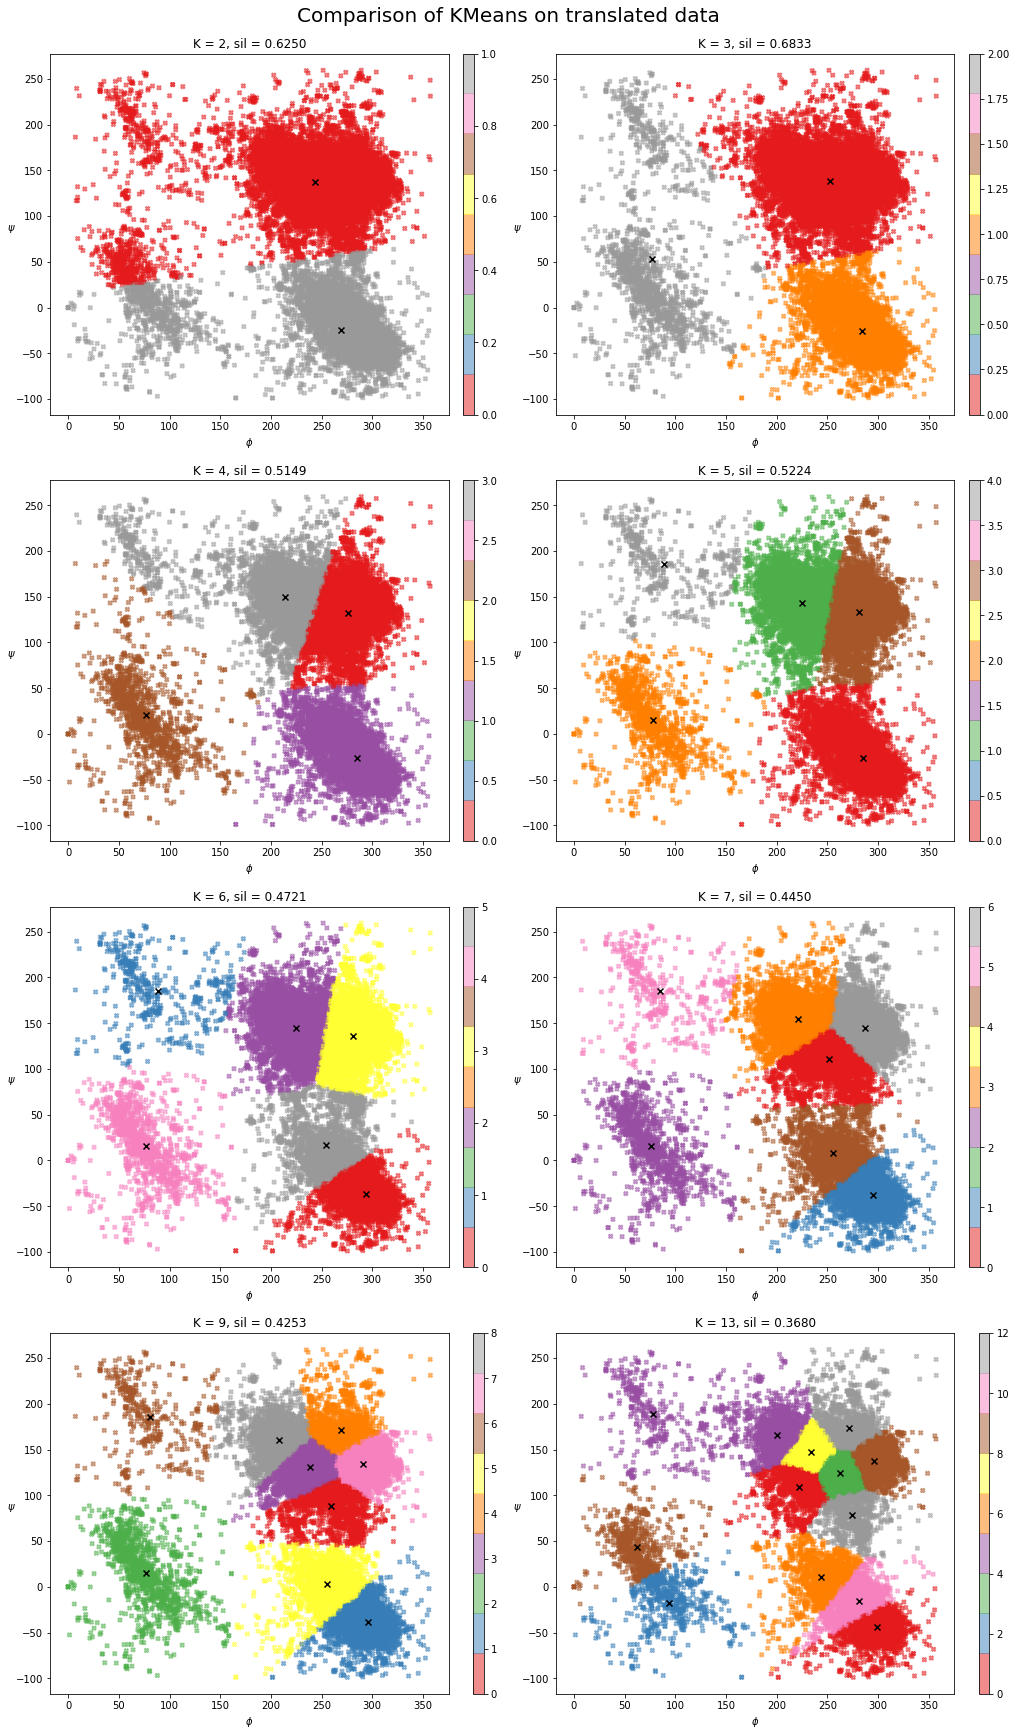

In [157]:
# KMeans to test data on
ks = [2,3,4,5,6,7,9,13]

# Setup subplots
fig,axs = plt.subplots(int(len(ks)/2),2, figsize=(2*7, int(len(ks)/2)*6),
                       constrained_layout=True)
axs = axs.flatten()

for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k).fit(translated[['phi', 'psi']])
    clusters = kmeans.cluster_centers_
    
    translated.plot.scatter(x="phi", y="psi", alpha = 0.5, ax=axs[i], 
                            c=kmeans.labels_, cmap="Set1", marker='X')
    
    axs[i].set_title(f"K = {k}, sil = {silhouette_score(translated[['phi', 'psi']], kmeans.labels_):,.4f}"
                     , size=15)
    axs[i].scatter(x=clusters[:,0], y=clusters[:,1], c="Black", marker="x")
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal", size=15)
    axs[i].set_xlabel(r"$\phi$", size=15)

fig.suptitle("Comparison of KMeans on translated data", size=20)
plt.show()

## 3. Use the DBSCAN method to cluster the phi and psi angle combinations in the data file.

### a. Motivate: 
#### i. the  choice  of the  minimum number  of  samples in  the neighbourhood for a point to be considered as a core point, and 
#### ii.the  choice  of the  maximum distance between two  samples  belonging to the same neighbourhood (“eps” or “epsilon”)

### b. Highlight  the  clusters  found  using  DBSCAN  and  any  outliers  in  a  scatter  plot. How  many  outliers  are  found?  Plot  a  bar  chart  to  show  which  amino  acid residue types are most frequently outliers

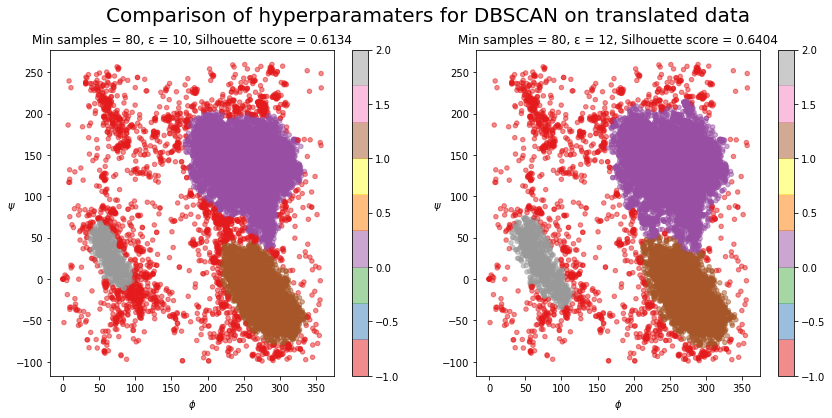

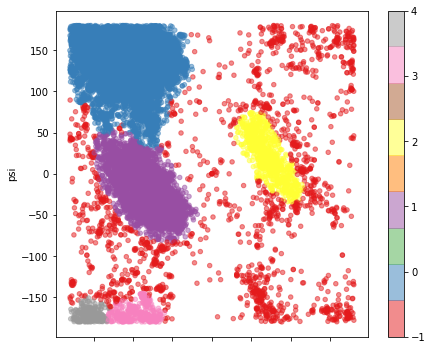

In [61]:
from sklearn.cluster import DBSCAN

testParams = [(10,80),(12,80)]

# Configure Subplots
fig,axs = plt.subplots(int(len(testParams)/2),2,
                       figsize=(2*7, int(len(testParams)/2)*6),
                       constrained_layout=True)
axs = axs.flatten()

# Translated data
for i, x in enumerate(testParams):
    dbcluster = DBSCAN(eps=x[0], min_samples=x[1]).fit(translated[['phi','psi']])
    translated.plot.scatter(x="phi", y="psi", alpha = 0.5, c=dbcluster.labels_, cmap="Set1", ax=axs[i])
    axs[i].set_title(f"Min samples = {x[1]}, ε = {x[0]}, Silhouette score = {silhouette_score(translated[['phi','psi']], dbcluster.labels_):,.4f}")
    axs[i].set_ylabel(r"$\psi$", rotation="horizontal")
    axs[i].set_xlabel(r"$\phi$")
    
fig.suptitle("Comparison of hyperparamaters for DBSCAN on translated data", size=20)
plt.show()
    
#Org data - TODO
plt.rcParams['figure.figsize'] = [7,6]
dbcluster = DBSCAN(eps=12, min_samples=80).fit(data[['phi','psi']])
data.plot.scatter(x="phi", y="psi", alpha = 0.5, c=dbcluster.labels_, cmap="Set1")
plt.show()

Nr of outliers in plot 1582


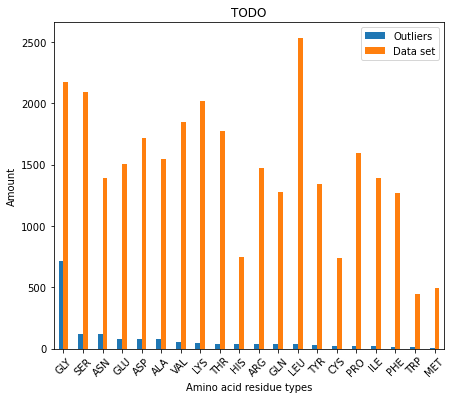

In [68]:
# TODO run dbscan with choosen hyper paramaters
dbcluster = DBSCAN(eps=12, min_samples=80).fit(translated[['phi','psi']])

# Filter outliers
translated["label"] = dbcluster.labels_
transOutlires = translated[translated.label==-1]

print(f"Nr of outliers in plot {transOutlires.phi.count()}")

# Count 
countRes = transOutlires["residue name"].value_counts().to_frame()
org = data["residue name"].value_counts().to_frame()

# Merge dataframes
countRes = countRes.merge(org, left_index=True, right_index=True)
countRes.columns = ["Outliers", "Data set"]

# Plot data
countRes.plot.bar()
plt.xticks(rotation=45)
plt.xlabel("Amino acid residue types")
plt.ylabel("Amount")
plt.title("TODO")
plt.show()

### c. Compare the clusters found by DBSCAN with those found using K-means

finds fewer clusters. Doesn't split clusters as much

### d. Discuss whether the clusters found using DBSCAN are robust to small changes in  the  minimum  number  of  samples  in  the  neighbourhood  for  a  point  to  be considered  as  a  core  point,  and/or  the  choice  of  the  maximum  distance between   two   samples   belonging   to   the   same   neighbourhood   (“eps”   or “epsilon”)

It's volatile

## 4. The data file can be stratified by amino acid residue type.  

### a. Use  DBSCAN to cluster the data that have residue type  PRO. Investigate how the clusters found for amino acid residues of type PRO differ from the general clusters (i.e., the clusters that you get from DBSCAN with mixed residue types in question 3).

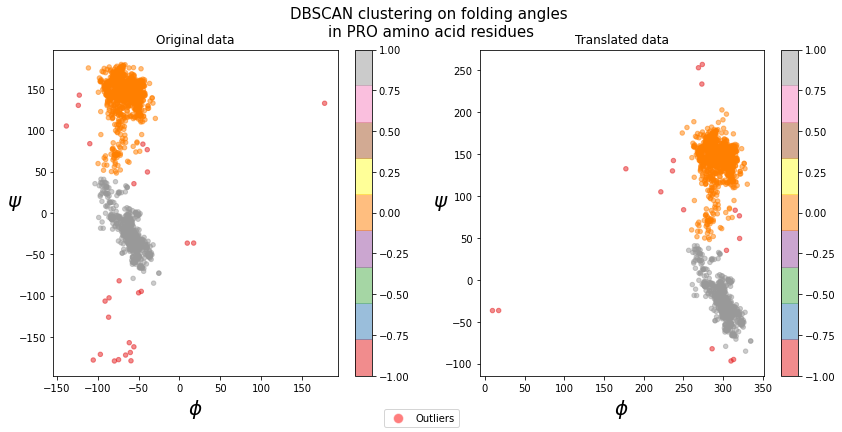

In [162]:
# Prepare subplots
plt.rcParams['figure.figsize'] = [14,6]
fig, axs = plt.subplots(1,2)

# Filter data and run dbscan on translated data
proTransData = translated[translated["residue name"] == "PRO"]
dbcluster2 = DBSCAN(eps=20, min_samples=40).fit(proTransData[['phi','psi']])

proTransData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                          c=dbcluster2.labels_, cmap="Set1", ax=axs[1])

# Configure plot   
axs[1].set_title("Translated data")
axs[1].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[1].set_xlabel(r"$\phi$", size=20)

# Filter data and run dbscan on original data
proData = data[data["residue name"] == "PRO"]
dbcluster3 = DBSCAN(eps=20, min_samples=40).fit(proData[['phi','psi']])

proData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                     c=dbcluster3.labels_, cmap="Set1", ax=axs[0])

# Configure plot    
axs[0].set_title("Original data")
axs[0].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[0].set_xlabel(r"$\phi$", size=20)

# Configure figure
fig.legend(loc="lower center", handles=
           [Line2D([0], [0], marker='o', color='w', label='Outliers', 
                   markerfacecolor='red', markersize=10, alpha=0.5)])
fig.suptitle("DBSCAN clustering on folding angles \nin PRO amino acid residues", 
             size=15)
plt.show()

Above we've plotted the clustes found by DBSCAN on both the translated data from question 2d and on the orginial data for proteins with residue type PRO. In both cases we find the same two clusters with very few outliers and can conclude that this clustering was not affected by the translation of the data.

In the plots we also see that the clusters match two of the bright areas in the heatmap and two of the main clusters found in question 2 and 3. Hence amino acids with type PRO have similar folding angles as the majority of the overall data. This is also backed up by the bar graph in question 2b where there almost no residues of type PRO among the outlires.

### b. Now use DBSCAN to cluster the data that have residue type GLY. Investigate how the clusters found for amino acid residues of type GLY differ from the general clusters. 


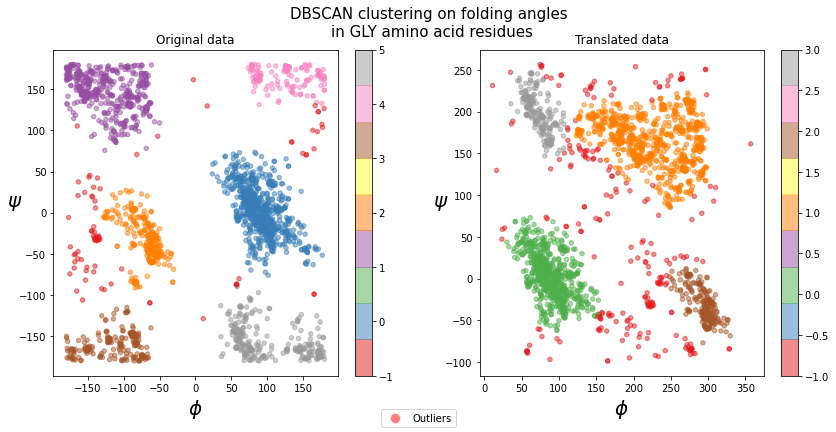

In [171]:
# Prepare subplots
plt.rcParams['figure.figsize'] = [14,6]
fig, axs = plt.subplots(1,2)

# Filter data and run dbscan on translated data
glyTransData = translated[translated["residue name"] == "GLY"]
dbcluster4 = DBSCAN(eps=17, min_samples=30).fit(glyTransData[['phi','psi']])

glyTransData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                          c=dbcluster4.labels_, cmap="Set1", ax=axs[1])

# Configure plot   
axs[1].set_title("Translated data")
axs[1].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[1].set_xlabel(r"$\phi$", size=20)

# Filter data and run dbscan on original data
glyData = data[data["residue name"] == "GLY"]
dbcluster5 = DBSCAN(eps=25, min_samples=30).fit(glyData[['phi','psi']])

glyData.plot.scatter(x="phi", y="psi", alpha = 0.5, 
                     c=dbcluster5.labels_, cmap="Set1", ax=axs[0])

# Configure plot    
axs[0].set_title("Original data")
axs[0].set_ylabel(r"$\psi$", rotation="horizontal", size=20)
axs[0].set_xlabel(r"$\phi$", size=20)

# Configure figure
fig.legend(loc="lower center", handles=
           [Line2D([0], [0], marker='o', color='w', label='Outliers', 
                   markerfacecolor='red', markersize=10, alpha=0.5)])
fig.suptitle("DBSCAN clustering on folding angles \nin GLY amino acid residues", 
             size=15)
plt.show()

Above we've plotted the clustes found by DBSCAN on both the translated data from question 2d and on the orginial data for amino acids of residue type GLY. In the left plot DBSCAN found 6 different clusters where several of the clusters are cut in half by the border of the plot. As discussed in 2d this is due to the cyclical nature of angles. We see that in the right scatterplot 4 clusters and non of these end right at the border of a plot. Hence translating the data helped to create clearer clusters. 

